# Brain Tumor Classification with ResNet

## Data Preparation

In [139]:
# import libraries

import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, makedirs
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import torch
from utils import train, evaluate
from tqdm.notebook import tqdm
from torch import optim 
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def crop_imgs(img_set, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in img_set:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


In [4]:
!unzip tumor_dataset.zip

Archive:  tumor_dataset.zip
  inflating: no/1 no.jpeg            
  inflating: no/10 no.jpg            
  inflating: no/11 no.jpg            
  inflating: no/12 no.jpg            
  inflating: no/13 no.jpg            
  inflating: no/14 no.jpg            
  inflating: no/15 no.jpg            
  inflating: no/17 no.jpg            
  inflating: no/18 no.jpg            
  inflating: no/19 no.jpg            
  inflating: no/2 no.jpeg            
  inflating: no/20 no.jpg            
  inflating: no/21 no.jpg            
  inflating: no/22 no.jpg            
  inflating: no/23 no.jpg            
  inflating: no/24 no.jpg            
  inflating: no/25 no.jpg            
  inflating: no/26 no.jpg            
  inflating: no/27 no.jpg            
  inflating: no/28 no.jpg            
  inflating: no/29 no.jpg            
  inflating: no/3 no.jpg             
  inflating: no/30 no.jpg            
  inflating: no/31 no.jpg            
  inflating: no/32 no.jpg            
  inflating: no/33 no.

In [5]:
def augment(img_set, dest_dir, num_replication):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest')

    for img in img_set:
        img = img.reshape((1,) + img.shape)
        count = 0
        for batch in data_gen.flow(x=img, batch_size=1, save_to_dir=dest_dir, save_format='jpg'):
            count += 1
            if count > num_replication:
                break

In [6]:
def plot_img(img, title=""):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title(title)

In [7]:
def read_imgs(file_dir):
    img_set = []
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        img_set.append(image)
    return img_set    

In [8]:
yes_img_set = read_imgs('yes')
no_img_set = read_imgs('no')

In [9]:
print("pos data count: ", len(yes_img_set))
print("neg data count: ", len(no_img_set))

pos data count:  155
neg data count:  98


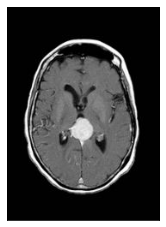

In [10]:
plot_img(yes_img_set[22])

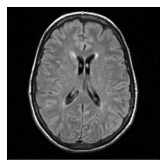

In [11]:
plot_img(no_img_set[2])

In [12]:
yes_img_set_cropped = crop_imgs(yes_img_set)
no_img_set_cropped = crop_imgs(no_img_set)

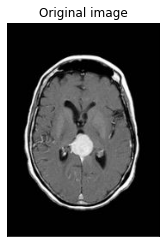

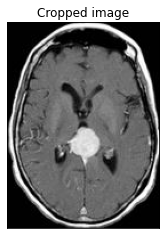

In [13]:
plot_img(yes_img_set[22], "Original image")
plot_img(yes_img_set_cropped[22], "Cropped image")

In [14]:
try:
    makedirs('augmented/yes')
    makedirs('augmented/no')
except:
    pass    

In [15]:
augment(yes_img_set_cropped, 'augmented/yes', 7)
augment(no_img_set_cropped, 'augmented/no', 8)

In [16]:
num_yes = len(listdir('augmented/yes'))
num_no = len(listdir('augmented/no'))
    
print("Dataset Size:" , num_yes + num_no)
print("Positive samples num:", num_yes, ", Percentage:", num_yes/(num_yes + num_no) * 100)
print("Negative samples num:", num_no, ", Percentage:", num_no/(num_yes + num_no) * 100)

Dataset Size: 1999
Positive samples num: 1163 , Percentage: 58.17908954477239
Negative samples num: 836 , Percentage: 41.82091045522761


In [246]:
def load_data(X, y, data_dir, target):
    for filename in listdir(data_dir):
        img = cv2.imread(data_dir + '/' + filename)
        img = cv2.resize(img, dsize=(240, 240))
        X.append([img[:, :, 0]])
        y.append(target)  
    return X, y 

In [247]:
X, y = [], []
X, y = load_data(X, y, 'augmented/yes', 1)
X, y = load_data(X, y, 'augmented/no', 0)
X = np.array(X)
y = np.array(y)
X, y = shuffle(X, y)

In [248]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(np.eye(2)[y]).float().to(device)
print(y.shape)
data = TensorDataset(X, y)

t, v = int(len(data)*0.7), int(len(data)*0.1)
train_data, test_data = random_split(data, [t + v, len(data) - t - v])
train_data, val_data = random_split(train_data, [t, v])

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

torch.Size([1999, 2])


In [250]:
y[0].shape

torch.Size([2])

In [251]:
for batch in train_loader:
  x, y = batch
  print(x.shape, y.shape)
  break

torch.Size([4, 1, 240, 240]) torch.Size([4, 2])


In [152]:
len(train_data), len(test_data), len(val_data)

(1399, 401, 199)

In [156]:
print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X[0].shape}')
print(f'y shape is: {y.shape}')

Number of examples is: 1999
X shape is: torch.Size([3, 240, 240])
y shape is: torch.Size([1999, 1])


## Model

In [170]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, k, s, bn_flag, dp_flag):
        super(ResidualBlock, self).__init__()
        layers = []
        layers += [nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding = (k-s+2)//2, bias=True)]
        if bn_flag:
          layers += [nn.BatchNorm2d(out_c)]   
        layers +=  [nn.ReLU()]
        if dp_flag:
          layers += [nn.Dropout(p = 0.3)]
        layers += [nn.Conv2d(out_c, out_c, kernel_size=k, stride=1, padding = (k-s+2)//2, bias=True)]
        if bn_flag:
          layers += [nn.BatchNorm2d(out_c)]  
        layers +=  [nn.ReLU()]
        if dp_flag:
          layers += [nn.Dropout(p = 0.3)]
        if in_c != out_c:
            layers += [nn.Conv2d(in_c, out_c, kernel_size=1, stride=s, padding=(1-s+2)//2, bias=True)]
            if bn_flag:
              layers += [nn.BatchNorm2d(out_c)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [261]:
class ResNet(nn.Module):
    def __init__(self, num_classes, bn_flag, dp_flag):
        super(ResNet, self).__init__()
        self.block1 = ResidualBlock(in_c=1, out_c=8, k=7, s=2, bn_flag=bn_flag, dp_flag=dp_flag)
        self.block2 = ResidualBlock(in_c=8, out_c=16, k=5, s=2, bn_flag=bn_flag, dp_flag=dp_flag)
        self.block3 = ResidualBlock(in_c=16, out_c=32, k=3, s=2, bn_flag=bn_flag, dp_flag=dp_flag)
        self.fc = nn.Linear(28800 , num_classes, bias=True)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        o = self.block1(x) 
        o = self.block2(o)  
        o = self.block3(o)  
        o = o.view(-1, 28800) 
        o = self.fc(o)
        o = self.softmax(o)
        return o

In [262]:
resnet = ResNet(2, False, False)

## Classification


In [254]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, k, s, bn_flag, dp_flag):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding = (k-s+2)//2, bias=True)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=k, stride=1, padding = (k-s+2)//2, bias=True)
        self.bn_flag = bn_flag
        self.dp_flag = dp_flag
        if bn_flag:
            self.batch_norm =  nn.BatchNorm2d(out_c)
        if dp_flag:
            self.drop_out =  nn.Dropout(p = 0.3)
        self.relu = nn.ReLU()
        self.downsample = nn.Sequential()
        if in_c != out_c:
            self.downsample = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=1, stride=s, padding=(1-s+2)//2, bias=True))


    def forward(self, x):
        o = self.conv1(x)
        if self.bn_flag:
            o = self.batch_norm(o)
        o = self.relu(o)
        if self.dp_flag:
            o = self.drop_out(o)
        o = self.conv2(o)
        if self.bn_flag:
            o = self.batch_norm(o)
        o = self.relu(o)
        if self.dp_flag:
            o = self.drop_out(o)
        o += self.downsample(x)
        return o

In [264]:
criterion = nn.CrossEntropyLoss()
resnet.to(device)

ResNet(
  (block1): ResidualBlock(
    (conv1): Conv2d(1, 8, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv2): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
    (downsample): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
    (downsample): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    )
  )
  (fc): Linear(in_features=28800, out_features=2, bias=True)
  (softmax): Softmax(dim

In [266]:
def train(model, t_loader, v_loader, criterion, optimizer, device='cuda:0', epochs=100, verbose=1, checkpoint=200):
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []
    for epoch in tqdm(range(epochs)):
        train_loss = []
        train_acc = []

        # TRAINING LOOP
        for train_batch in t_loader:
            x, y = train_batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            train_loss.append(loss.item())
            train_acc.append((torch.argmax(logits.data, 1) == torch.argmax(y, 1)).sum().item() / y.size(0))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
        log = '\r{} train_loss:{} train_acc:{}\n'.format(epoch + 1, train_loss, train_acc)

        val_loss, val_acc = evaluate(model, v_loader, criterion, device)

        log += 'val_loss:{} val_acc:{}\n'.format(val_loss, val_acc)

        log_train_loss.append(train_loss)
        log_train_acc.append(train_acc)
        log_val_loss.append(val_loss)
        log_val_acc.append(val_acc)

        if (epoch + 1) % verbose == 0:
            print(log)

        if (epoch + 1) % checkpoint == 0:
            save(model, 'weights/', 'cls_' + str(epoch + 1))

    return log_train_loss, log_train_acc, log_val_loss, log_val_acc


def evaluate(model, loader, criterion, device):
    # VALIDATION LOOP
    with torch.no_grad():
        val_loss = []
        val_acc = []
        for val_batch in loader:
            x, y = val_batch
            x, y = x.to(device), y.to(device)
            logits = model(x)
            val_loss.append(criterion(logits, y).item())
            val_acc.append((torch.argmax(logits.data, 1) == torch.argmax(y, 1)).sum().item() / y.size(0))

        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        return val_loss, val_acc

In [270]:
log_train_loss, log_train_acc, log_val_loss, log_val_acc = train(resnet, train_loader, val_loader, nn.BCELoss(), optim.Adam(resnet.parameters(), lr=1e-4))

1 train_loss:41.26190477643694 train_acc:0.5873809523809524
val_loss:42.666666717529296 val_acc:0.5733333333333334

2 train_loss:41.23809524536133 train_acc:0.5876190476190476
val_loss:42.666666717529296 val_acc:0.5733333333333334

3 train_loss:41.23809524536133 train_acc:0.5876190476190476
val_loss:42.666666717529296 val_acc:0.5733333333333334

4 train_loss:41.214285714285715 train_acc:0.5878571428571429
val_loss:42.83333343505859 val_acc:0.5716666666666667

5 train_loss:41.23809524536133 train_acc:0.5876190476190476
val_loss:42.83333343505859 val_acc:0.5716666666666667

6 train_loss:41.214285714285715 train_acc:0.5878571428571429
val_loss:42.5 val_acc:0.575

7 train_loss:41.23809524536133 train_acc:0.5876190476190476
val_loss:42.666666717529296 val_acc:0.5733333333333334

8 train_loss:41.23809524536133 train_acc:0.5876190476190476
val_loss:42.83333343505859 val_acc:0.5716666666666667

9 train_loss:41.26190477643694 train_acc:0.5873809523809524
val_loss:42.666666717529296 val_acc:0.57

### Loss and Accuracy Plots

## Furthur investigation


### Batch Normalization

### Dropout

### Visualization

In [271]:
def plot_metric(train_metric, val_metric, title):
    plt.figure()
    plt.plot(train_metric, label='Training' + title)
    plt.plot(val_metric, label='Validation' + title)
    plt.title(title)
    plt.legend()
    plt.show()

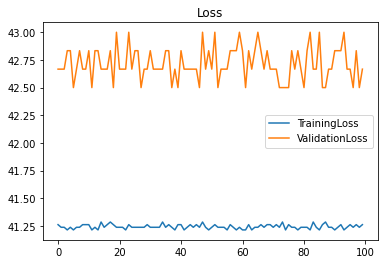

In [273]:
plot_metric(log_train_loss, log_val_loss, 'Loss')

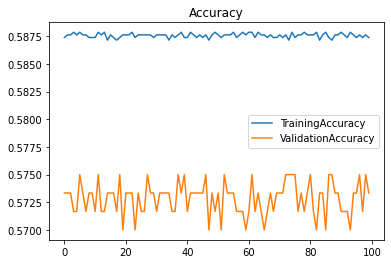

In [274]:
plot_metric(log_train_acc, log_val_acc, 'Accuracy')